<a href="https://colab.research.google.com/github/Chanura04/ML-Coursework/blob/main/20240955.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
!pip install keras-tuner
!pip install tensorflow

In [2]:
import pandas as pd
# from google.colab import drive
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
import keras_tuner as kt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras import layers, regularizers
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (
    StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)

## Load the dataset

In [3]:
url = "https://raw.githubusercontent.com/Chanura04/ML-Coursework/main/dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv"

## Check dataset behaviour

In [4]:
df=pd.read_csv(url)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.shape

(7043, 21)

In [6]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [8]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [9]:
df["SeniorCitizen"].value_counts()

SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64

In [10]:
categorical_cols=['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod',"Churn"]
numerical_cols=['MonthlyCharges','TotalCharges','tenure']

In [11]:
len(categorical_cols)+len(numerical_cols)

20

In [12]:
#corr_matrix=df[numerical_cols].corr()
#corr_matrix

#This will shows error because the TotalCharges data type is string.

In [13]:
def convert_to_numeric(value):
    try:
        return float(value)
    except ValueError:
        return None

df['TotalCharges'] = df['TotalCharges'].apply(convert_to_numeric)

In [14]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [15]:
corr_matrix=df[numerical_cols].corr()
corr_matrix

,MonthlyCharges,TotalCharges,tenure
MonthlyCharges,1.000000,0.651065,0.24790
TotalCharges,0.651065,1.000000,0.82588
tenure,0.247900,0.825880,1.00000


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [17]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

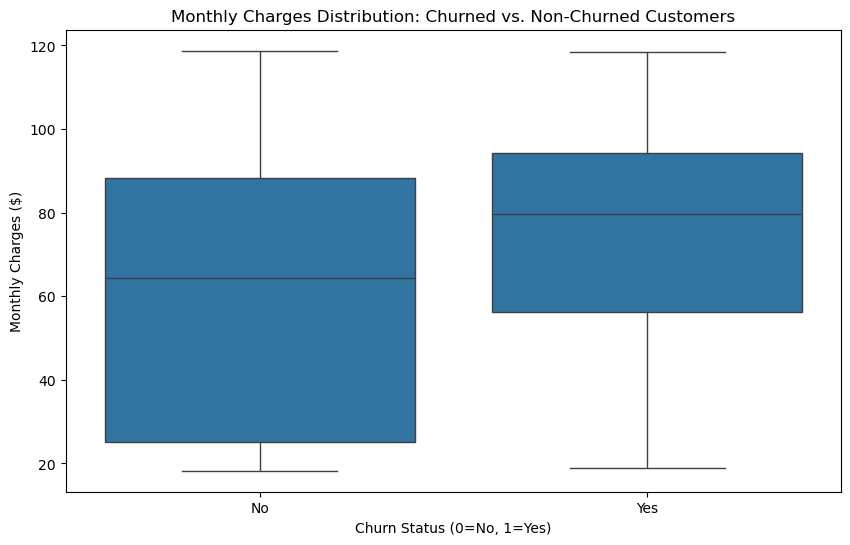

In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Monthly Charges Distribution: Churned vs. Non-Churned Customers')
plt.xlabel('Churn Status (0=No, 1=Yes)')
plt.ylabel('Monthly Charges ($)')
plt.show()

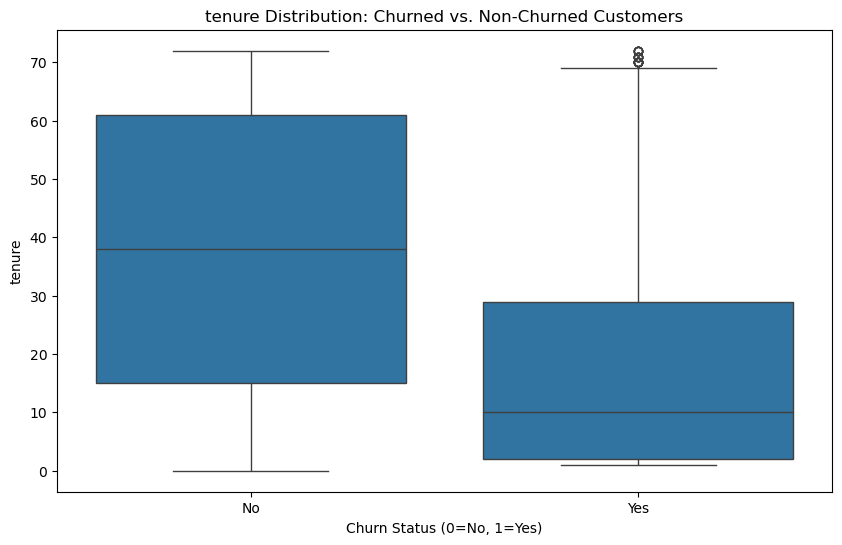

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('tenure Distribution: Churned vs. Non-Churned Customers')
plt.xlabel('Churn Status (0=No, 1=Yes)')
plt.ylabel('tenure')
plt.show()

## Categorical Variables Distribution

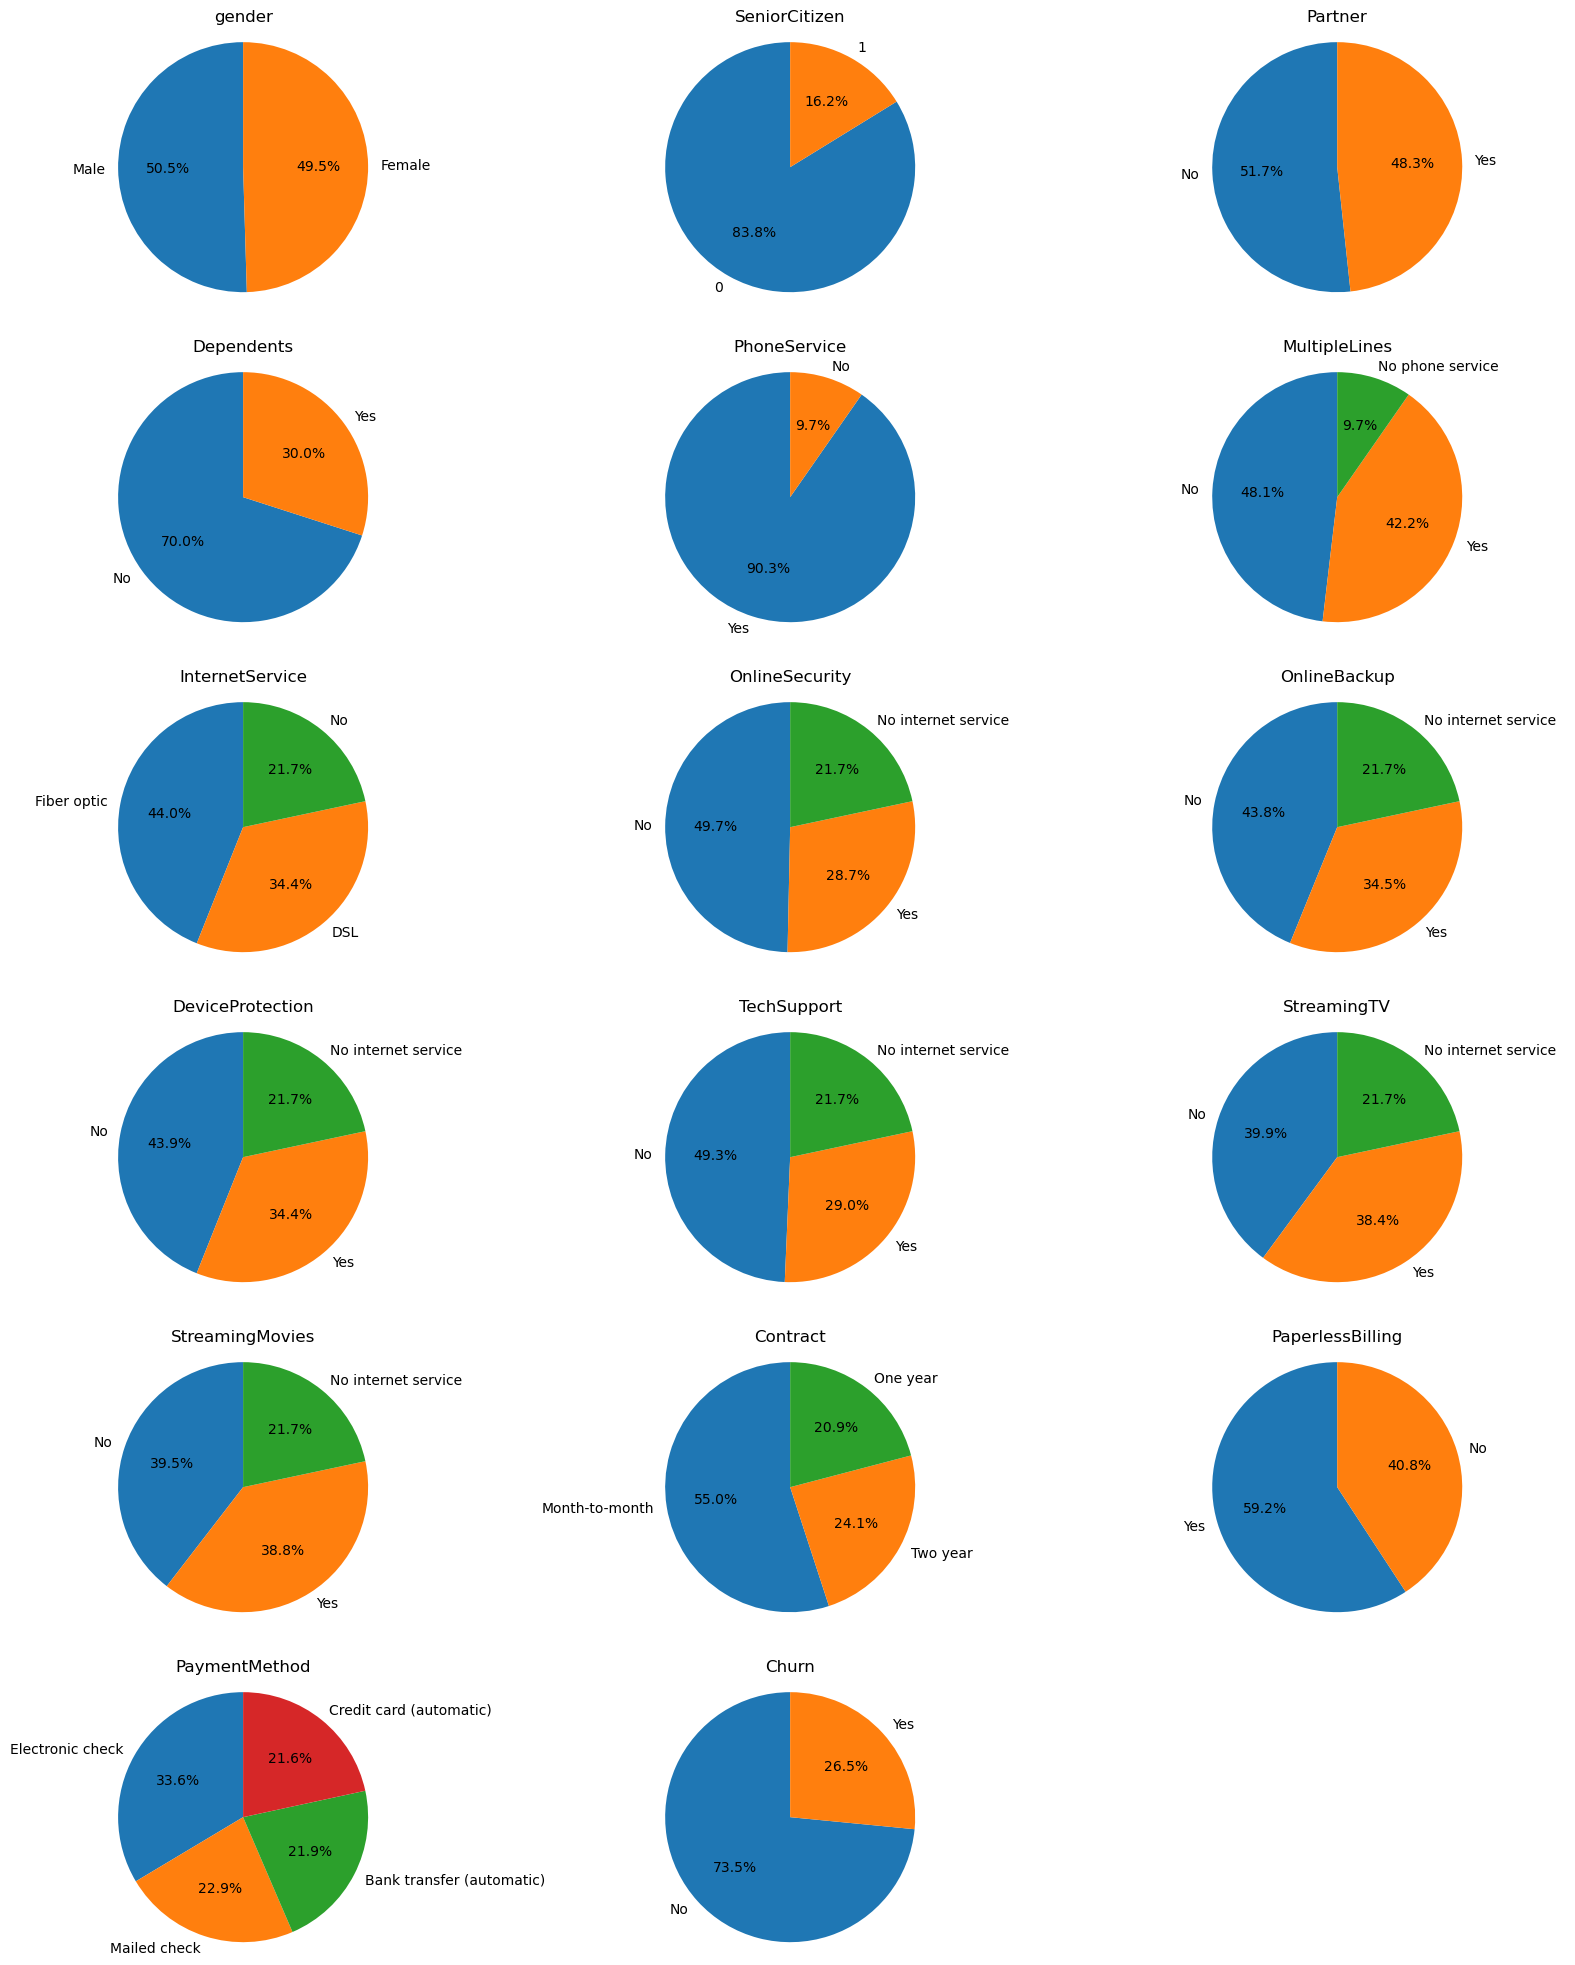

In [20]:
plt.figure(figsize=(20, 25))
for i, col in enumerate(categorical_cols):
    plt.subplot(6, 3, i + 1)
    plt.pie(df[col].value_counts().values, labels=df[col].value_counts().index, autopct='%1.1f%%', startangle=90)
    plt.title(f'Distribution of {col}')
    plt.axis('equal')
    plt.title(col)
plt.show()

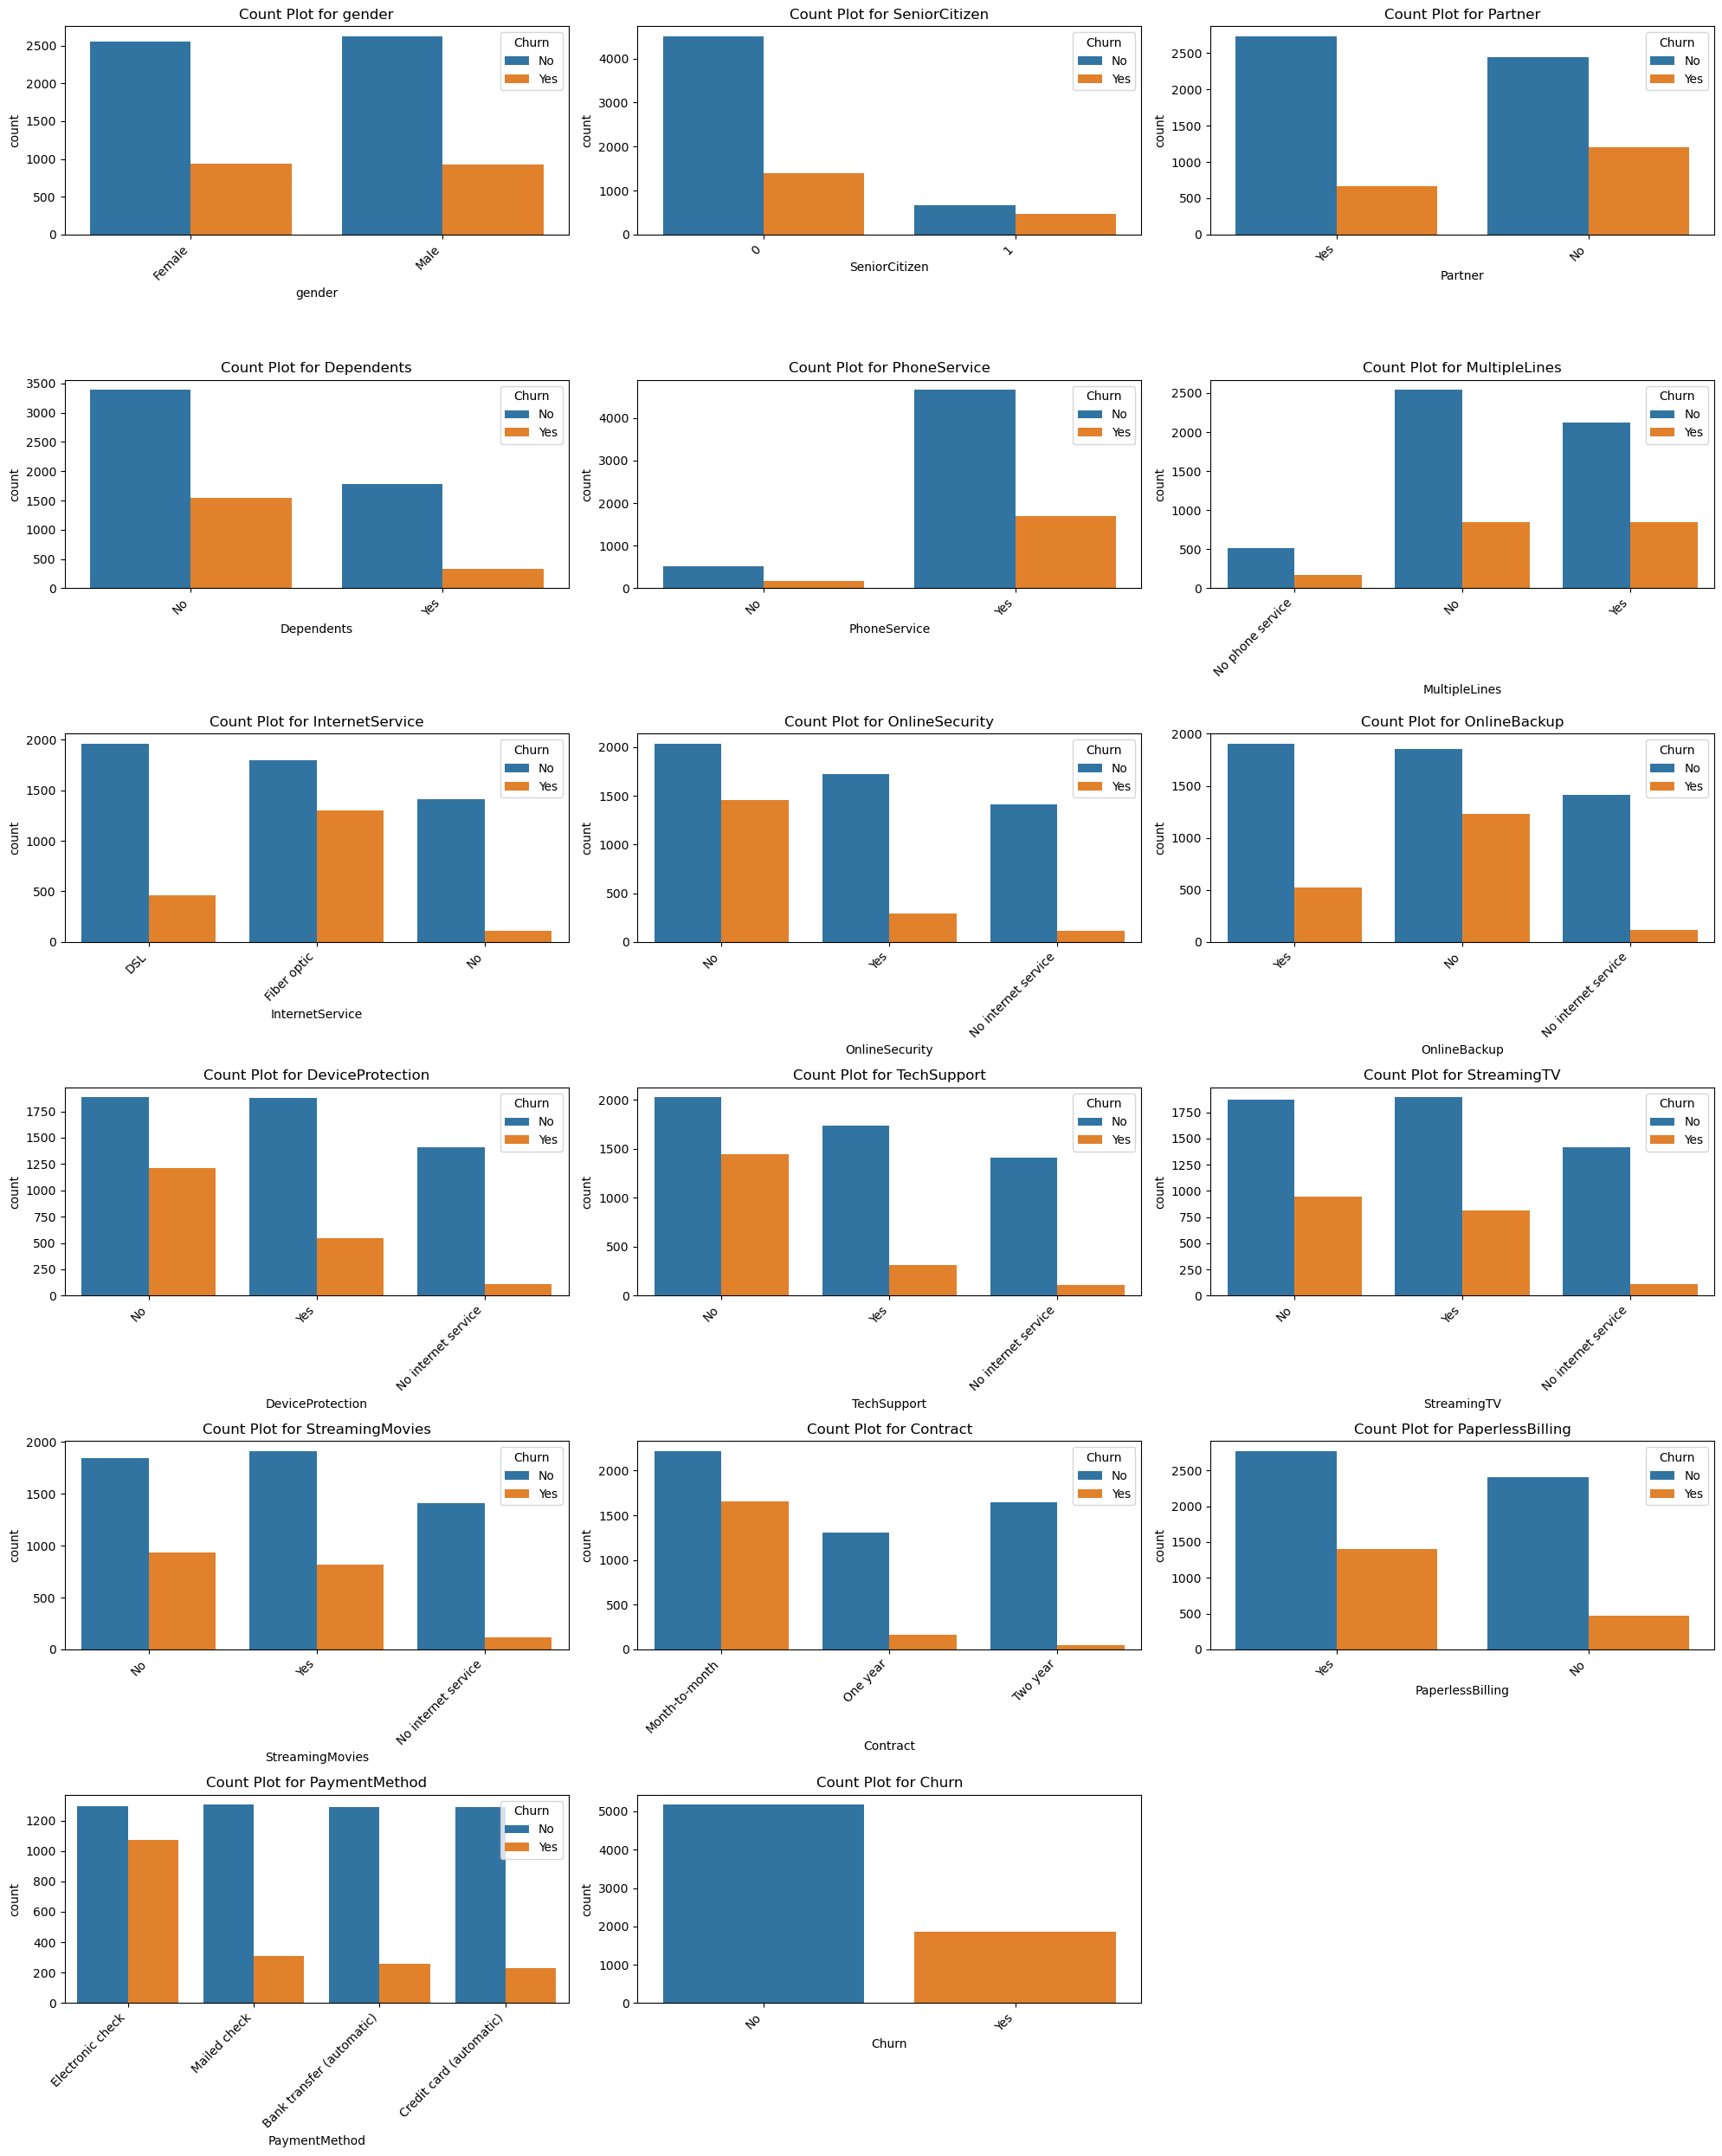

In [21]:
plt.figure(figsize=(20, 25))
for i, col in enumerate(categorical_cols):
    plt.subplot(6, 3, i + 1)
    sns.countplot(data=df, x=col, hue='Churn')
    plt.title(f'Count Plot for {col}')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Numerical Variables Distribution

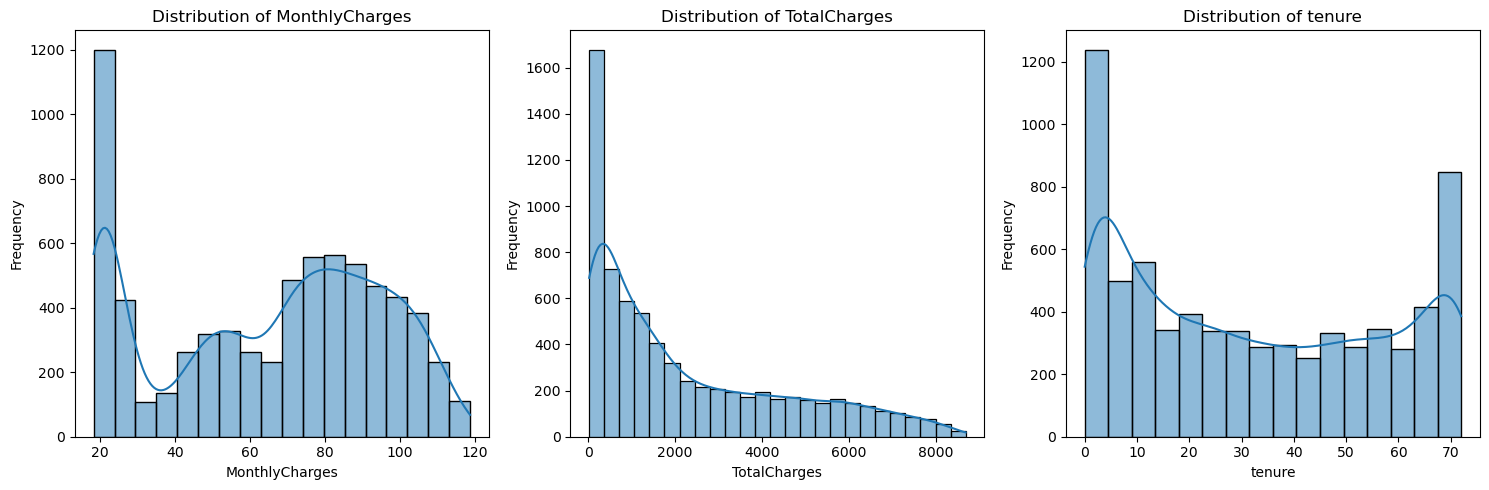

In [22]:
plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, 3, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

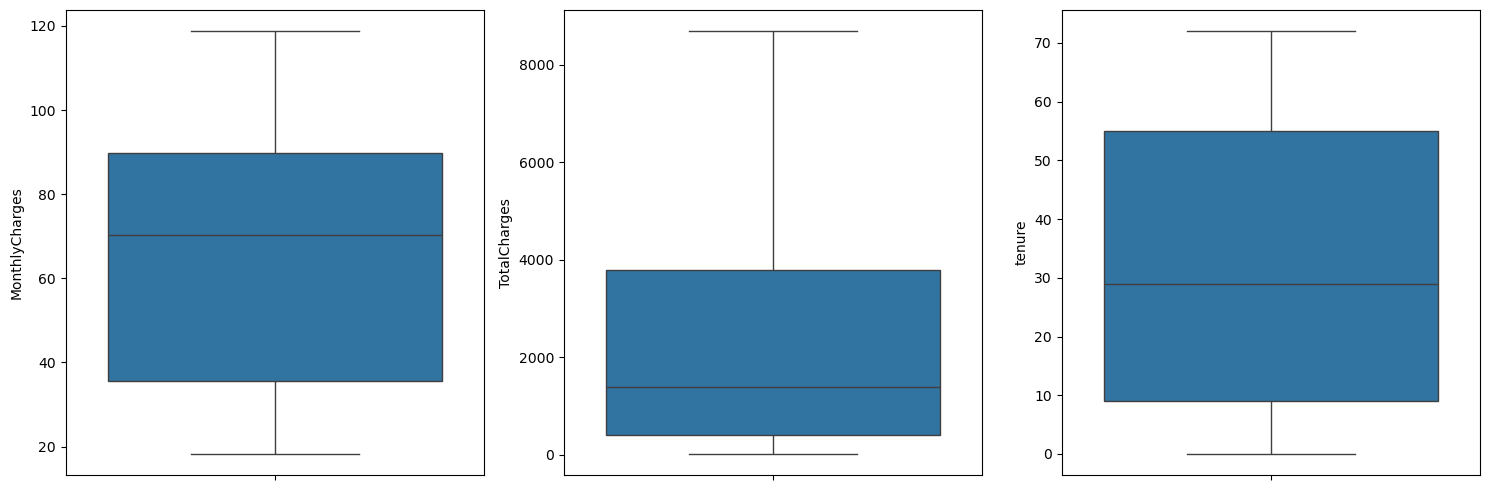

In [23]:
plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(data=df[col])
    # plt.title(f'{col} by Churn')
    # plt.xlabel('Churn')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

## Data Preprocessing

In [24]:
categorical_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [25]:
numerical_cols

['MonthlyCharges', 'TotalCharges', 'tenure']

In [26]:
df_cp=df.copy()

In [27]:
df_cp = df_cp.drop(columns=['customerID'])
df_cp.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [28]:
len(df_cp.columns)

20

In [29]:
df_cp.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [30]:
df_cp["SeniorCitizen"].isnull().sum()


np.int64(0)

In [31]:
df_cp.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [32]:
df_cp['TotalCharges']=df_cp['TotalCharges'].fillna(df_cp['TotalCharges'].median())

In [33]:
df_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [34]:
for col in df_cp.columns:
  # print(col)
  value=df_cp[col].value_counts()
  print(value)
  print('*'*50)
  print("\n")

gender
Male      3555
Female    3488
Name: count, dtype: int64
**************************************************


SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64
**************************************************


Partner
No     3641
Yes    3402
Name: count, dtype: int64
**************************************************


Dependents
No     4933
Yes    2110
Name: count, dtype: int64
**************************************************


tenure
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: count, Length: 73, dtype: int64
**************************************************


PhoneService
Yes    6361
No      682
Name: count, dtype: int64
**************************************************


MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64
**************************************************


InternetService
Fiber optic    3096
DSL            242

In [35]:
for col in df_cp.columns:
  print("\n")
  print(col)
  print(df_cp[col].unique())

  print("\n")
  print('*'*50)




gender
['Female' 'Male']


**************************************************


SeniorCitizen
[0 1]


**************************************************


Partner
['Yes' 'No']


**************************************************


Dependents
['No' 'Yes']


**************************************************


tenure
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]


**************************************************


PhoneService
['No' 'Yes']


**************************************************


MultipleLines
['No phone service' 'No' 'Yes']


**************************************************


InternetService
['DSL' 'Fiber optic' 'No']


**************************************************


OnlineSecurity
['No' 'Yes' 'No internet service']


**************************************************


OnlineBackup
['Ye

In [36]:
# In this dataset there are some features both represent same meaning.Here i convert those to one
df_cp['MultipleLines'] = df_cp['MultipleLines'].replace('No phone service', 'No')
df_cp[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
      'TechSupport', 'StreamingTV', 'StreamingMovies']] = df_cp[['OnlineSecurity', 'OnlineBackup',
                                                                'DeviceProtection', 'TechSupport',
                                                                'StreamingTV', 'StreamingMovies']].replace('No internet service', 'No')

In [37]:
df_cp

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


In [38]:
# SeniorCitizen is a binary categorical feature
categorical_cols=['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod',"Churn"]
numerical_cols=['MonthlyCharges','TotalCharges','tenure']
len(categorical_cols)

17

In [39]:
label_encoding_columns=['gender','Partner','Dependents','PhoneService','PaperlessBilling','Churn','MultipleLines','OnlineSecurity','OnlineBackup',
                        'DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

one_hot_encoding_columns=['InternetService','Contract','PaymentMethod']

len(label_encoding_columns)+len(one_hot_encoding_columns)

16

<Axes: >

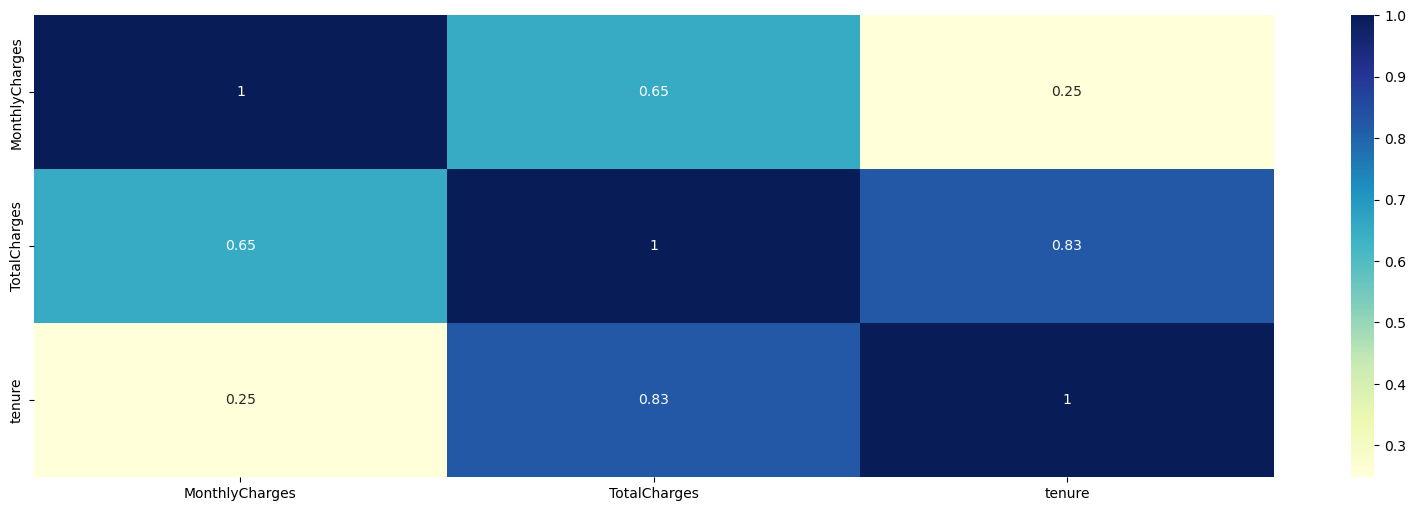

In [40]:
plt.figure(figsize=(20, 6))
sns.heatmap(df_cp[numerical_cols].corr(), cmap = 'YlGnBu', annot = True)

#### Label Encoding

In [41]:
#Label encoding method use for binary categories
l_encoder=LabelEncoder()

for col in label_encoding_columns:
  df_cp[col]=l_encoder.fit_transform(df_cp[col])

In [42]:
df_cp.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,1,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,1,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,1,0,0,0,45,0,0,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,0,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


#### One-Hot Encoding

In [43]:
#One-Hot encoder use for multi class categories
oneHot_encoder=OneHotEncoder(sparse_output=False,drop=None)
encoded_data=oneHot_encoder.fit_transform(df_cp[one_hot_encoding_columns])
oneHot_encoded_df=pd.DataFrame(encoded_data,columns=oneHot_encoder.get_feature_names_out(one_hot_encoding_columns))

In [44]:
df_cp_final=df_cp.drop(columns=one_hot_encoding_columns)
df_cp_final=pd.concat([df_cp_final,oneHot_encoded_df],axis=1)
df_cp_final.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,0,1,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0,0,0,34,1,0,1,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1,0,0,0,2,1,0,1,1,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,0,0,0,45,0,0,1,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0,0,0,0,2,1,0,0,0,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [45]:
df_cp_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   gender                                   7043 non-null   int64  
 1   SeniorCitizen                            7043 non-null   int64  
 2   Partner                                  7043 non-null   int64  
 3   Dependents                               7043 non-null   int64  
 4   tenure                                   7043 non-null   int64  
 5   PhoneService                             7043 non-null   int64  
 6   MultipleLines                            7043 non-null   int64  
 7   OnlineSecurity                           7043 non-null   int64  
 8   OnlineBackup                             7043 non-null   int64  
 9   DeviceProtection                         7043 non-null   int64  
 10  TechSupport                              7043 no

#### Scale Numerical Features

In [46]:
# std_sclr=StandardScaler()
#
# for col in numerical_cols:
#   df_cp_final[col]=std_sclr.fit_transform(df_cp_final[[col]])
#
# df_cp_final

In [47]:
for col in df_cp.columns:
  print("\n")
  print(col)
  print(df_cp[col].unique())

  print("\n")
  print('*'*50)



gender
[0 1]


**************************************************


SeniorCitizen
[0 1]


**************************************************


Partner
[1 0]


**************************************************


Dependents
[0 1]


**************************************************


tenure
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]


**************************************************


PhoneService
[0 1]


**************************************************


MultipleLines
[0 1]


**************************************************


InternetService
['DSL' 'Fiber optic' 'No']


**************************************************


OnlineSecurity
[0 1]


**************************************************


OnlineBackup
[1 0]


**************************************************


DeviceProtection
[0 1]


******

#### Handle class imbalance

In [48]:
df_cp_final['Churn'].value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

In [49]:
# Need to handle this,because of this class imbalance ML model can become biased toward the majority class

In [50]:
df_cp_final.isnull().sum()

gender                                     0
SeniorCitizen                              0
Partner                                    0
Dependents                                 0
tenure                                     0
PhoneService                               0
MultipleLines                              0
OnlineSecurity                             0
OnlineBackup                               0
DeviceProtection                           0
TechSupport                                0
StreamingTV                                0
StreamingMovies                            0
PaperlessBilling                           0
MonthlyCharges                             0
TotalCharges                               0
Churn                                      0
InternetService_DSL                        0
InternetService_Fiber optic                0
InternetService_No                         0
Contract_Month-to-month                    0
Contract_One year                          0
Contract_T

In [51]:
X=df_cp_final.drop(columns=['Churn'],axis=1)
y=df_cp_final['Churn']


In [52]:
X

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,0,1,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0,0,0,34,1,0,1,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1,0,0,0,2,1,0,1,1,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,0,0,0,45,0,0,1,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0,0,0,0,2,1,0,0,0,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,1,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7039,0,0,1,1,72,1,1,0,1,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7040,0,0,1,1,11,0,0,1,0,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7041,1,1,1,0,4,1,1,0,0,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [53]:
y

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7043, dtype: int64

In [54]:
# smote=SMOTE(random_state=42)
# X_resampled,y_resampled=smote.fit_resample(X,y)

In [55]:
# y_resampled.value_counts()

In [56]:
# count=y_resampled.value_counts()
# count.plot(kind='bar')
# plt.xlabel('Churn')
# plt.ylabel('Count')
# plt.title('Count Plot for Churn')

### Split Data into Training, Validation, and Test Sets

In [57]:
# X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_temp, y_train, y_temp= train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test= train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (4930, 26)
Shape of y_train: (4930,)
Shape of X_val: (1056, 26)
Shape of y_val: (1056,)
Shape of X_test: (1057, 26)
Shape of y_test: (1057,)


In [58]:
np.sum(y_val==1)

np.int64(280)

In [59]:
np.sum(y_val==0)

np.int64(776)

In [60]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


In [61]:
# 2. Initialize the scaler
scaler = StandardScaler()

# 3. FIT AND TRANSFORM the training data (Learns the mean/std and applies the scaling)
X_train = scaler.fit_transform(X_train)

# 4. ONLY TRANSFORM the test data (Applies the mean/std learned from the training data)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [62]:
X_train[0]

array([-0.86491011, -0.39085667, -0.76833605, -0.51960175, -0.94205683,
        0.34812163, -0.79284117, -0.50930152, -0.61564723, -0.6209798 ,
       -0.52495398,  1.3229474 , -0.74823939, -1.23061152,  0.41813912,
       -0.75926071, -0.67727687,  0.95699003, -0.44701491,  0.73085155,
       -0.46294185, -0.45961109, -0.50371663, -0.49438736,  1.24739147,
       -0.53098644])

Text(0.5, 1.0, 'Count Plot for Churn')

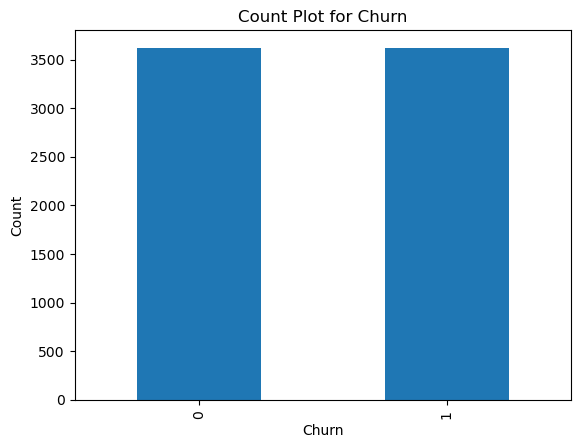

In [63]:
count=y_train.value_counts()
count.plot(kind='bar')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.title('Count Plot for Churn')

In [64]:
def plot_history(history):
    # Loss
    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Binary Crossentropy")
    plt.legend()


    # Accuracy
    plt.subplot(1,3,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()


    # AUC
    plt.subplot(1,3,3)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title("AUC Curve")
    plt.xlabel("Epochs")
    plt.ylabel("AUC Score")
    plt.legend()
    plt.show()




## Train Neural Network

In [65]:
input_dim=X_train.shape[1]
input_dim

26

#### Test 01 without hyperparameters

In [66]:
import tensorflow as tf

# 7. Baseline Keras model
def make_baseline_model(input_dim):
    model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(input_dim,)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=[keras.metrics.AUC(name='auc', from_logits=False), 'accuracy'])
    return model

baseline = make_baseline_model(input_dim)
baseline.summary()

# Train baseline
history_test_01 = baseline.fit(X_train, y_train, validation_data=(X_val,y_val),
                       epochs=30, batch_size=64,
                       callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)],
                       verbose=2)

c:\Users\chanu\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,841 (15.00 KB)

 Trainable params: 3,841 (15.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
114/114 - 1s - 11ms/step - accuracy: 0.7540 - auc: 0.8312 - loss: 0.5072 - val_accuracy: 0.7547 - val_auc: 0.8147 - val_loss: 0.5127
Epoch 2/30
114/114 - 0s - 2ms/step - accuracy: 0.8002 - auc: 0.8820 - loss: 0.4307 - val_accuracy: 0.7557 - val_auc: 0.8137 - val_loss: 0.5076
Epoch 3/30
114/114 - 0s - 2ms/step - accuracy: 0.8062 - auc: 0.8883 - loss: 0.4203 - val_accuracy: 0.7614 - val_auc: 0.8161 - val_loss: 0.4980
Epoch 4/30
114/114 - 0s - 4ms/step - accuracy: 0.8132 - auc: 0.8921 - loss: 0.4137 - val_accuracy: 0.7576 - val_auc: 0.8170 - val_loss: 0.4977
Epoch 5/30
114/114 - 0s - 2ms/step - accuracy: 0.8176 - auc: 0.8960 - loss: 0.4067 - val_accuracy: 0.7491 - val_auc: 0.8161 - val_loss: 0.5127
Epoch 6/30
114/114 - 0s - 2ms/step - accuracy: 0.8199 - auc: 0.8995 - loss: 0.4005 - val_accuracy: 0.7680 - val_auc: 0.8176 - val_loss: 0.4791
Epoch 7/30
114/114 - 0s - 2ms/step - accuracy: 0.8229 - auc: 0.9011 - loss: 0.3975 - val_accuracy: 0.7519 - val_auc: 0.8193 - val_loss: 0.512

In [67]:
# 8. Evaluate baseline
y_pred_proba_test_01 = baseline.predict(X_test).ravel()
y_pred_test_01 = (y_pred_proba_test_01 >= 0.5).astype(int)
print("Accuracy:", accuracy_score(y_test, y_pred_test_01))
print("AUC:", roc_auc_score(y_test, y_pred_proba_test_01))
print(classification_report(y_test, y_pred_test_01))


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.78240302743614
AUC: 0.8329924423083978
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       776
           1       0.59      0.61      0.60       281

    accuracy                           0.78      1057
   macro avg       0.72      0.73      0.72      1057
weighted avg       0.79      0.78      0.78      1057



In [68]:
print("\n=== Final Training vs Validation Performance ===")

# Get the metrics from the last epoch (or best epoch if early stopping restored weights)
train_loss = history_test_01.history['loss'][-1]
train_accuracy = history_test_01.history['accuracy'][-1]
train_auc = history_test_01.history['auc'][-1]

val_loss = history_test_01.history['val_loss'][-1]
val_accuracy = history_test_01.history['val_accuracy'][-1]
val_auc = history_test_01.history['val_auc'][-1]

print(f"Training   - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, AUC: {train_auc:.4f}")
print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, AUC: {val_auc:.4f}")
print(f"Test       -        Accuracy: {accuracy_score(y_test, y_pred_test_01):.4f}, AUC: {roc_auc_score(y_test, y_pred_proba_test_01):.4f}")

print("Test precision:", precision_score(y_test, y_pred_test_01))
print("Test recall:", recall_score(y_test, y_pred_test_01))
print("Test f1:", f1_score(y_test, y_pred_test_01))


=== Final Training vs Validation Performance ===
Training   - Loss: 0.3874, Accuracy: 0.8240, AUC: 0.9062
Validation - Loss: 0.4823, Accuracy: 0.7633, AUC: 0.8175
Test       -        Accuracy: 0.7824, AUC: 0.8330
Test precision: 0.5870307167235495
Test recall: 0.6120996441281139
Test f1: 0.5993031358885017


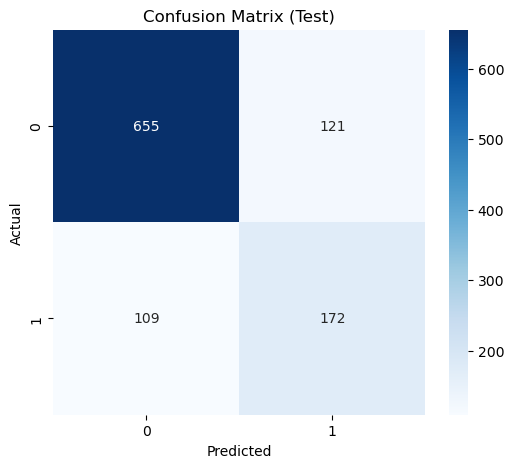

In [69]:
cm=confusion_matrix(y_test,y_pred_test_01)
cm
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


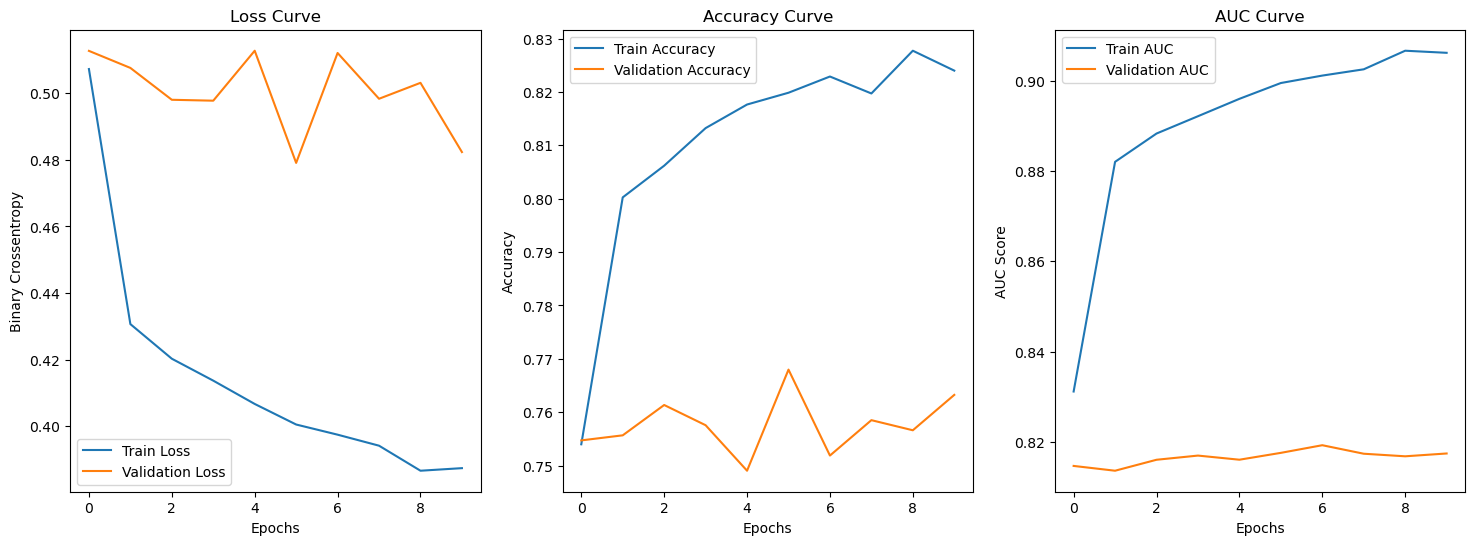

In [70]:
plot_history(history_test_01)


#### Test 02 with hyperparameters

In [71]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: w for i, w in enumerate(class_weights)}
print("Class weights:", class_weights)

Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}


In [72]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(input_dim,)))
    # tune number of layers 1-3
    for i in range(hp.Int('num_layers', 1, 3)):
        units = hp.Int(f'units_{i}', min_value=16, max_value=256, step=16)
        model.add(keras.layers.Dense(units, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
        # optional dropout
        if hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1) > 0:
            model.add(keras.layers.Dropout(hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1)))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # optimizer + learning rate
    opt_choice = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    if opt_choice == 'adam':
        lr = hp.Float('adam_lr', 1e-4, 1e-2, sampling='log')
        optimizer = keras.optimizers.Adam(learning_rate=lr)
    elif opt_choice == 'rmsprop':
        lr = hp.Float('rmsprop_lr', 1e-4, 1e-2, sampling='log')
        optimizer = keras.optimizers.RMSprop(learning_rate=lr)
    else:
        lr = hp.Float('sgd_lr', 1e-4, 1e-2, sampling='log')
        optimizer = keras.optimizers.SGD(learning_rate=lr)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=[keras.metrics.AUC(name='auc', from_logits=False), 'accuracy'])
    return model

tuner_test_02 = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_auc", direction="max"),
    max_trials=25,
    executions_per_trial=1,
    directory='model_his_9',
    project_name='telco_churn_ann_Test_2'
)

# starts the automated process of building, training, and evaluating the 25 different model configurations defined by the RandomSearch method.
tuner_test_02.search(X_train, y_train,
             epochs=100,
             validation_data=(X_val,y_val),
             class_weight=class_weights,
             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)],
             batch_size=512)

Reloading Tuner from model_his_9\telco_churn_ann_Test_2\tuner0.json


In [73]:
# 10. Get best model and evaluate on test
best_hps_test_01 = tuner_test_02.get_best_hyperparameters(num_trials=1)[0]
print(best_hps_test_01.values)

{'num_layers': 1, 'units_0': 240, 'dropout_0': 0.4, 'optimizer': 'adam', 'adam_lr': 0.003114165676160948, 'units_1': 224, 'dropout_1': 0.2, 'rmsprop_lr': 0.004385067052102108, 'units_2': 256, 'dropout_2': 0.0, 'sgd_lr': 0.0022466970035351194}


In [74]:
# 1. Get the best hyperparameters which gives highest val_auc
best_hps_test_02 = tuner_test_02.get_best_hyperparameters(1)[0]

# 2. Build the model using these hyperparameters
best_tuned_model_test_02 = build_model(best_hps_test_02)

# 3. Retrain the model so we get history (needed for visualization)
history_tuned_test_02 = best_tuned_model_test_02.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_val,y_val),
    class_weight=class_weights,
    batch_size=1024,
    callbacks=[keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=4, restore_best_weights=True
    )],
    verbose=2
)


Epoch 1/100


c:\Users\chanu\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


8/8 - 1s - 120ms/step - accuracy: 0.6628 - auc: 0.7339 - loss: 1.0427 - val_accuracy: 0.7481 - val_auc: 0.8184 - val_loss: 0.8936
Epoch 2/100
8/8 - 0s - 11ms/step - accuracy: 0.7887 - auc: 0.8702 - loss: 0.8033 - val_accuracy: 0.7396 - val_auc: 0.8218 - val_loss: 0.8176
Epoch 3/100
8/8 - 0s - 12ms/step - accuracy: 0.7989 - auc: 0.8821 - loss: 0.6899 - val_accuracy: 0.7538 - val_auc: 0.8193 - val_loss: 0.7059
Epoch 4/100
8/8 - 0s - 11ms/step - accuracy: 0.8036 - auc: 0.8880 - loss: 0.6034 - val_accuracy: 0.7491 - val_auc: 0.8126 - val_loss: 0.6357
Epoch 5/100
8/8 - 0s - 13ms/step - accuracy: 0.8102 - auc: 0.8917 - loss: 0.5456 - val_accuracy: 0.7491 - val_auc: 0.8130 - val_loss: 0.5971
Epoch 6/100
8/8 - 0s - 12ms/step - accuracy: 0.8123 - auc: 0.8923 - loss: 0.5064 - val_accuracy: 0.7585 - val_auc: 0.8182 - val_loss: 0.5706
Epoch 7/100
8/8 - 0s - 11ms/step - accuracy: 0.8099 - auc: 0.8917 - loss: 0.4810 - val_accuracy: 0.7557 - val_auc: 0.8194 - val_loss: 0.5569
Epoch 8/100
8/8 - 0s - 1

In [ ]:

 # Evaluate   
y_pred_tuned_proba_test_02 = best_tuned_model_test_02.predict(X_test).ravel()
y_pred_tuned_test_02 = (y_pred_tuned_proba_test_02 >= 0.5).astype(int)

print("Test AUC:", roc_auc_score(y_test, y_pred_tuned_proba_test_02))
print("Test Accuracy:", accuracy_score(y_test, y_pred_tuned_test_02))
print(classification_report(y_test, y_pred_tuned_test_02))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Test AUC: 0.8288742341416885
Test Accuracy: 0.7805108798486282
              precision    recall  f1-score   support

           0       0.87      0.82      0.85       776
           1       0.58      0.66      0.62       281

    accuracy                           0.78      1057
   macro avg       0.72      0.74      0.73      1057
weighted avg       0.79      0.78      0.79      1057



In [76]:
print("\n=== Final Training vs Validation Performance ===")

# Get the metrics from the last epoch (or best epoch if early stopping restored weights)
train_loss = history_tuned_test_02.history['loss'][-1]
train_accuracy = history_tuned_test_02.history['accuracy'][-1]
train_auc = history_tuned_test_02.history['auc'][-1]

val_loss = history_tuned_test_02.history['val_loss'][-1]
val_accuracy = history_tuned_test_02.history['val_accuracy'][-1]
val_auc = history_tuned_test_02.history['val_auc'][-1]

print(f"Training   - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, AUC: {train_auc:.4f}")
print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, AUC: {val_auc:.4f}")
print(f"Test Accuracy       -        Accuracy: {accuracy_score(y_test, y_pred_tuned_test_02):.4f}, AUC: {roc_auc_score(y_test,y_pred_tuned_proba_test_02):.4f}")

print("Test precision:", precision_score(y_test, y_pred_tuned_test_02))
print("Test recall:", recall_score(y_test, y_pred_tuned_test_02))
print("Test f1:", f1_score(y_test, y_pred_tuned_test_02))


=== Final Training vs Validation Performance ===
Training   - Loss: 0.4183, Accuracy: 0.8181, AUC: 0.9033
Validation - Loss: 0.5265, Accuracy: 0.7472, AUC: 0.8116
Test Accuracy       -        Accuracy: 0.7805, AUC: 0.8289
Test precision: 0.5758513931888545
Test recall: 0.6619217081850534
Test f1: 0.6158940397350994


In [77]:
print(f"Minimum Validation Loss: {min(history_tuned_test_02.history['val_loss']):.4f}")

Minimum Validation Loss: 0.5044


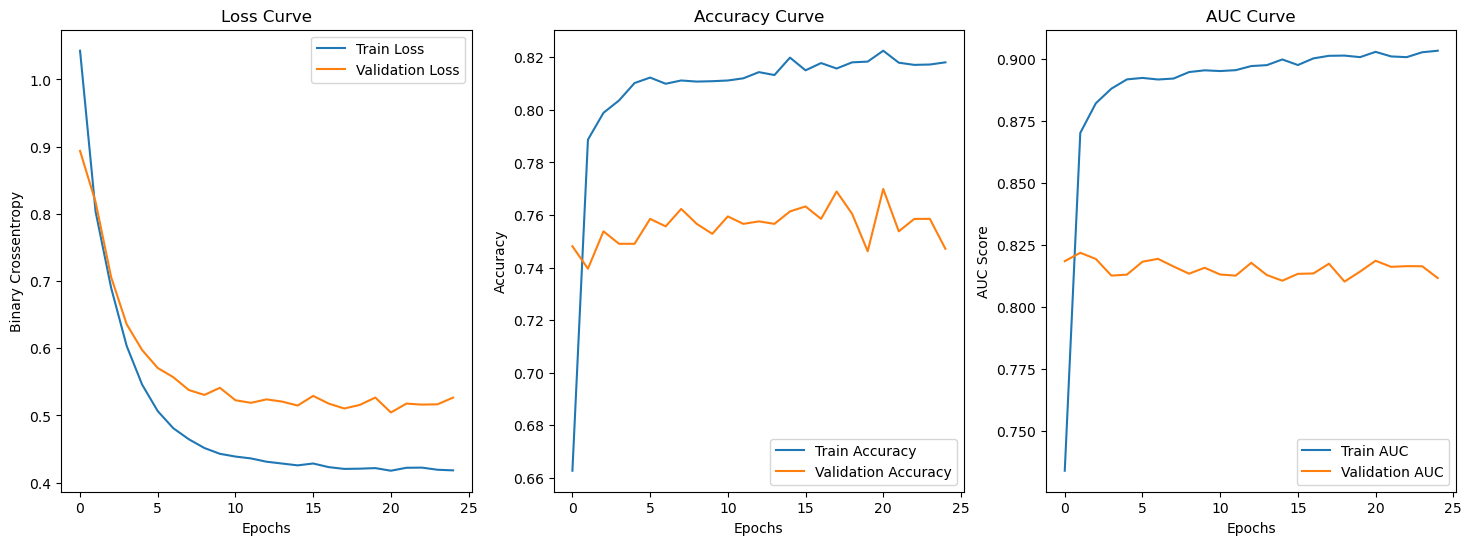

In [ ]:
plot_history(history_tuned_test_02)

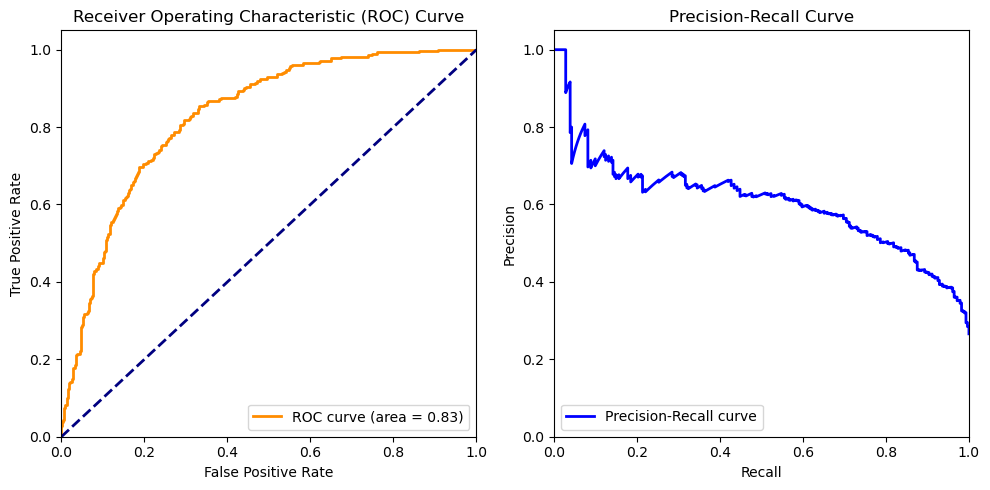

In [79]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# --- ROC Curve ---

fpr, tpr, thresholds = roc_curve(y_test, y_pred_tuned_proba_test_02)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# --- Precision-Recall Curve ---

precision, recall, _ = precision_recall_curve(y_test, y_pred_tuned_proba_test_02)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

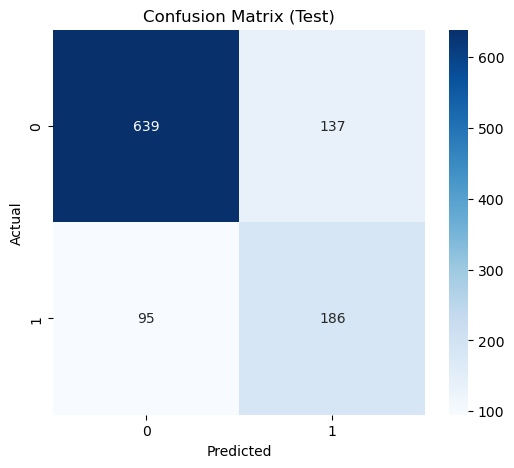

In [80]:
# best_model.save("telco_ann_best_model.h5")
cm=confusion_matrix(y_test,y_pred_tuned_test_02)
cm
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [81]:
cm

array([[639, 137],
       [ 95, 186]])

In [82]:
# os.makedirs("models", exist_ok=True)
#
# best_tuned_model_test_02.save("models/final_ann_model.keras")


In [83]:
cm


array([[639, 137],
       [ 95, 186]])

#### Test 03 with improved hyperparamters

In [84]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(input_dim,)))

    # Add batch normalization as an option
    use_batchnorm = hp.Boolean('use_batchnorm', default=False)

    for i in range(hp.Int('num_layers', 1, 4)):  # Hidden layers 1-4 layers
        units = hp.Choice(f'units_{i}', values=[32, 64, 128, 256, 512])  # Units per layers
        model.add(keras.layers.Dense(units))

        # batch normalization before activation
        if use_batchnorm:
            model.add(keras.layers.BatchNormalization())

        activation = hp.Choice(f'activation_{i}', ['relu', 'leaky_relu', 'elu'])
        if activation == 'leaky_relu':
            model.add(keras.layers.LeakyReLU(alpha=0.1))
        elif activation == 'elu':
            model.add(keras.layers.ELU())
        else:
            model.add(keras.layers.Activation('relu'))

        # Tune dropout regularization
        dropout_rate = hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1)
        if dropout_rate > 0:
            model.add(keras.layers.Dropout(dropout_rate))

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # L2 regularization tuning
    l2_reg = hp.Float('l2_reg', 1e-5, 1e-2, sampling='log')

    #  optimizer selection
    opt_choice = hp.Choice('optimizer', ['adam', 'adamw', 'rmsprop', 'sgd'])

    lr = hp.Float('lr', 1e-4, 1e-2, sampling='log')

    if opt_choice == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=lr)
    elif opt_choice == 'adamw':
        optimizer = keras.optimizers.AdamW(learning_rate=lr, weight_decay=l2_reg)
    elif opt_choice == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=lr)
    else:
        momentum = hp.Float('sgd_momentum', 0.5, 0.99, step=0.1)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=momentum)

    model.compile(
        optimizer=optimizer,
        #Label Smoothing
        loss=keras.losses.BinaryCrossentropy(label_smoothing=hp.Float('label_smoothing', 0.0, 0.2)),
        metrics=[
            keras.metrics.AUC(name='auc', from_logits=False),
            keras.metrics.BinaryAccuracy(name='accuracy'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall')
        ]
    )
    return model

# RandomSearch
tuner_test_03 = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_auc", direction="max"),
    max_trials=50,
    executions_per_trial=2,  # Run each configuration multiple times
    directory='model_his_9',
    project_name='telco_churn_ann_optimized',
    overwrite=True,
    seed=42  # For reproducibility
)
#tuner
tuner_test_03.search(X_train, y_train,
             epochs=100,
              validation_data=(X_val,y_val),
             class_weight=class_weights,
             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)],
             batch_size=64)

Trial 50 Complete [00h 00m 24s]
val_auc: 0.8220763504505157

Best val_auc So Far: 0.8371548354625702
Total elapsed time: 00h 15m 38s


In [85]:
# 10. Get best model and evaluate on test
best_hps_test_03 = tuner_test_03.get_best_hyperparameters(num_trials=1)[0]
print(best_hps_test_03.values)

{'use_batchnorm': False, 'num_layers': 4, 'units_0': 512, 'activation_0': 'elu', 'dropout_0': 0.2, 'l2_reg': 1.1579641844449379e-05, 'optimizer': 'adamw', 'lr': 0.0010733251249694183, 'label_smoothing': 0.03866905014894156, 'units_1': 256, 'activation_1': 'relu', 'dropout_1': 0.4, 'units_2': 32, 'activation_2': 'elu', 'dropout_2': 0.2, 'units_3': 256, 'activation_3': 'leaky_relu', 'dropout_3': 0.4, 'sgd_momentum': 0.9}


In [ ]:
# 1. Get the best hyperparameters
best_hps_test_03 = tuner_test_03.get_best_hyperparameters(1)[0]

# 2. Build the model using these hyperparameters
best_tuned_model_test_03 = build_model(best_hps_test_02)

# 3. Retrain the model so we get history
history_tuned_test_03 = best_tuned_model_test_03.fit(
    X_train, y_train,
    epochs=40,
   validation_data=(X_val,y_val),
    class_weight=class_weights,
    batch_size=1024,
    callbacks=[keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=4, restore_best_weights=True
    )],
    verbose=2
)

Epoch 1/40


In [ ]:
# Evaluate
y_pred_tuned_test_03_proba = best_tuned_model_test_03.predict(X_test).ravel()
y_pred_tuned_test_03 = (y_pred_tuned_test_03_proba >= 0.5).astype(int)
print("Test AUC:", roc_auc_score(y_test, y_pred_tuned_test_03_proba))
print("Test Accuracy:", accuracy_score(y_test, y_pred_tuned_test_03))
print(classification_report(y_test, y_pred_tuned_test_03))

NameError: name 'best_tuned_model_test_03' is not defined

In [ ]:
print("\n=== Final Training vs Validation Performance ===")

# Get the metrics from the last epoch (or best epoch if early stopping restored weights)
train_loss = history_tuned_test_03.history['loss'][-1]
train_accuracy = history_tuned_test_03.history['accuracy'][-1]
train_auc = history_tuned_test_03.history['auc'][-1]

val_loss = history_tuned_test_03.history['val_loss'][-1]
val_accuracy = history_tuned_test_03.history['val_accuracy'][-1]
val_auc = history_tuned_test_03.history['val_auc'][-1]

print(f"Training   - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, AUC: {train_auc:.4f}")
print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, AUC: {val_auc:.4f}")
print(f"Test       -        Accuracy: {accuracy_score(y_test, y_pred_tuned_test_03):.4f}, AUC: {roc_auc_score(y_test, y_pred_tuned_test_03_proba):.4f}")
print("Test precision:", precision_score(y_test, y_pred_tuned_test_03))
print("Test recall:", recall_score(y_test, y_pred_tuned_test_03))
print("Test f1:", f1_score(y_test, y_pred_tuned_test_03))


=== Final Training vs Validation Performance ===
Training   - Loss: 0.4459, Accuracy: 0.7957, AUC: 0.8745
Validation - Loss: 0.4921, Accuracy: 0.7652, AUC: 0.8192
Test       -        Accuracy: 0.7767, AUC: 0.8304
Test precision: 0.5671641791044776
Test recall: 0.6761565836298933
Test f1: 0.6168831168831169


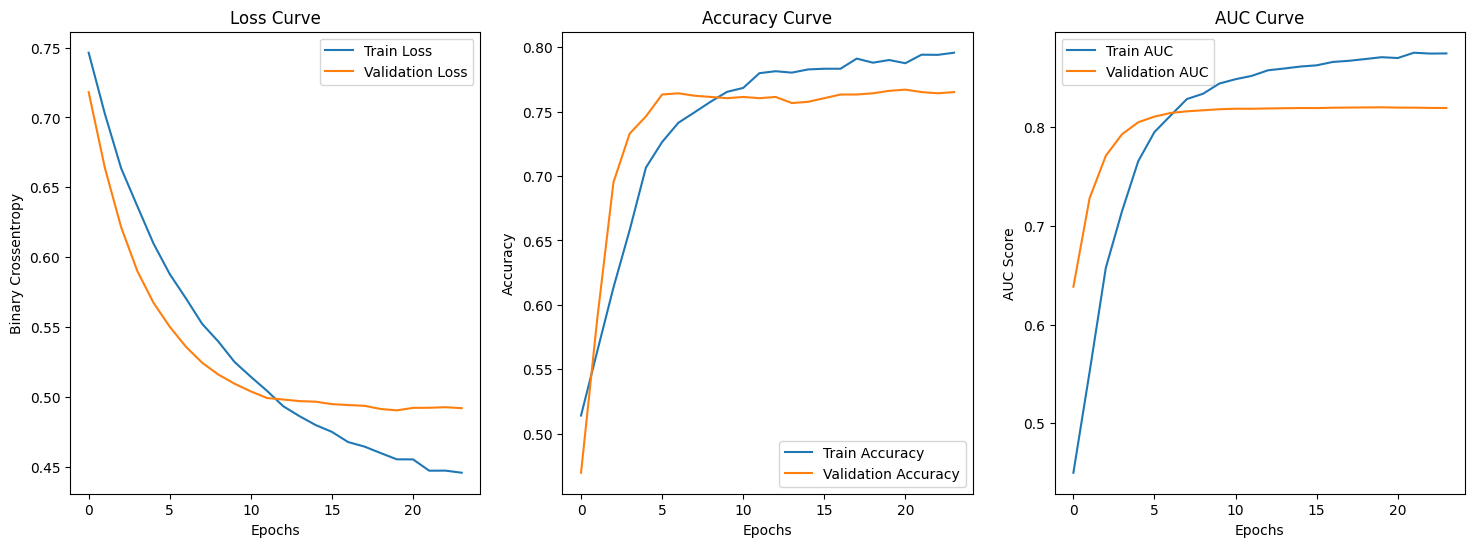

In [ ]:
plot_history(history_tuned_test_03)


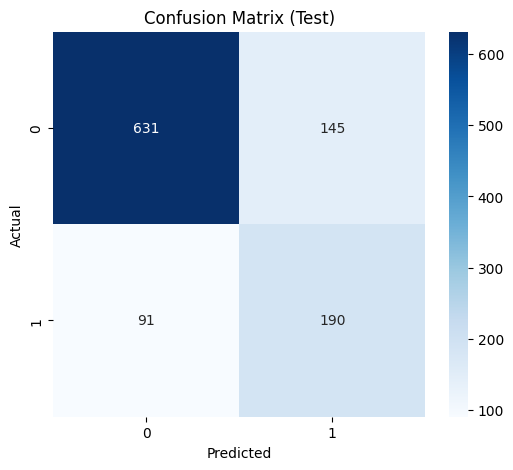

In [ ]:
cm=confusion_matrix(y_test,y_pred_tuned_test_03)
cm
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# os.makedirs("models", exist_ok=True)
#
# best_tuned_model_test_03.save("models/860_175__170_865_test_3.keras")

In [ ]:
best_hps_test_03 = tuner_test_03.get_best_hyperparameters(1)[0]

# 2. Build the model using these hyperparameters
best_tuned_model_test_03 = build_model(best_hps_test_02)

# 3. Retrain the model so we get history (needed for visualization)
history_tuned_test_03 = best_tuned_model_test_03.fit(
    X_train, y_train,
    epochs=100,
   validation_data=(X_val,y_val),
    class_weight=class_weights,
    batch_size=2048,
    callbacks=[keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=4, restore_best_weights=True
    )],
    verbose=2
)

Epoch 1/100
4/4 - 2s - 608ms/step - accuracy: 0.5552 - auc: 0.5690 - loss: 0.6975 - precision: 0.5350 - recall: 0.8432 - val_accuracy: 0.4025 - val_auc: 0.6403 - val_loss: 0.7309 - val_precision: 0.2933 - val_recall: 0.8893
Epoch 2/100
4/4 - 0s - 52ms/step - accuracy: 0.5867 - auc: 0.6208 - loss: 0.6766 - precision: 0.5586 - recall: 0.8269 - val_accuracy: 0.4839 - val_auc: 0.6848 - val_loss: 0.6998 - val_precision: 0.3182 - val_recall: 0.8286
Epoch 3/100
4/4 - 0s - 42ms/step - accuracy: 0.6222 - auc: 0.6726 - loss: 0.6556 - precision: 0.5882 - recall: 0.8150 - val_accuracy: 0.5843 - val_auc: 0.7195 - val_loss: 0.6720 - val_precision: 0.3664 - val_recall: 0.7786
Epoch 4/100
4/4 - 0s - 43ms/step - accuracy: 0.6564 - auc: 0.7152 - loss: 0.6365 - precision: 0.6222 - recall: 0.7962 - val_accuracy: 0.6411 - val_auc: 0.7406 - val_loss: 0.6477 - val_precision: 0.4020 - val_recall: 0.7250
Epoch 5/100
4/4 - 0s - 42ms/step - accuracy: 0.6811 - auc: 0.7419 - loss: 0.6214 - precision: 0.6512 - reca

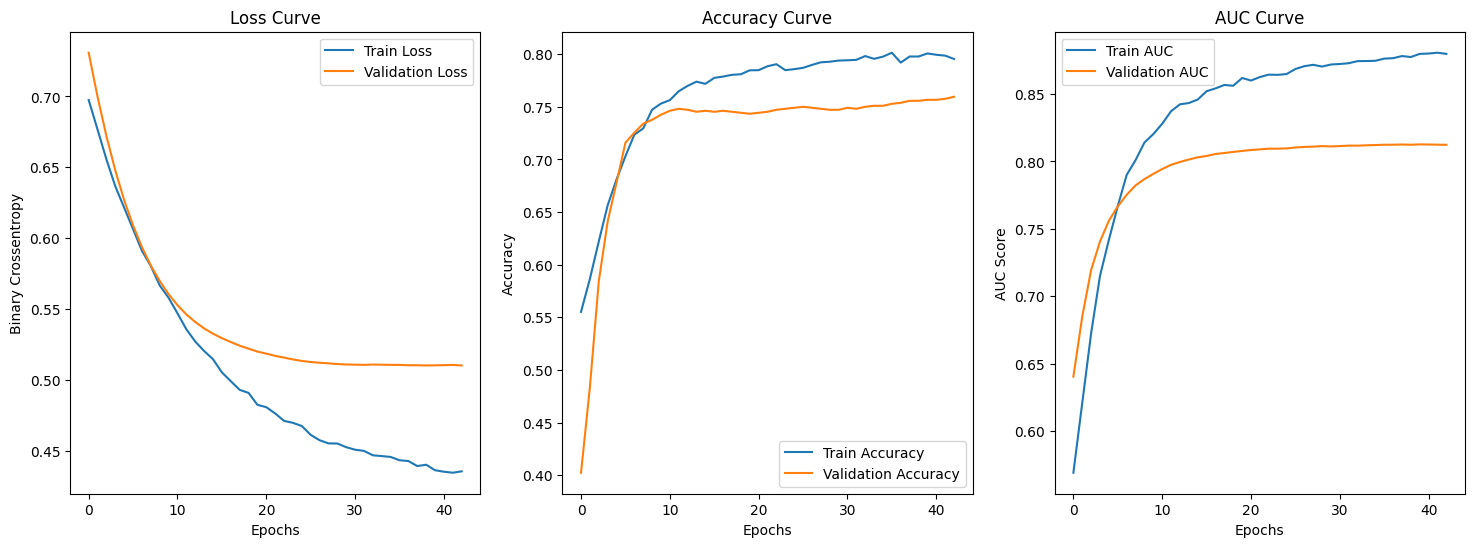

In [ ]:
plot_history(history_tuned_test_03)


In [ ]:
print("\n=== Final Training vs Validation Performance ===")

# Get the metrics from the last epoch (or best epoch if early stopping restored weights)
train_loss = history_tuned_test_03.history['loss'][-1]
train_accuracy = history_tuned_test_03.history['accuracy'][-1]
train_auc = history_tuned_test_03.history['auc'][-1]

val_loss = history_tuned_test_03.history['val_loss'][-1]
val_accuracy = history_tuned_test_03.history['val_accuracy'][-1]
val_auc = history_tuned_test_03.history['val_auc'][-1]

print(f"Training   - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, AUC: {train_auc:.4f}")
print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, AUC: {val_auc:.4f}")
print(f"Test       -        Accuracy: {accuracy_score(y_test, y_pred_tuned_test_03):.4f}, AUC: {roc_auc_score(y_test, y_pred_tuned_test_03_proba):.4f}")
print("Test precision:", precision_score(y_test, y_pred_tuned_test_03))
print("Test recall:", recall_score(y_test, y_pred_tuned_test_03))
print("Test f1:", f1_score(y_test, y_pred_tuned_test_03))


=== Final Training vs Validation Performance ===
Training   - Loss: 0.4353, Accuracy: 0.7954, AUC: 0.8798
Validation - Loss: 0.5101, Accuracy: 0.7595, AUC: 0.8123
Test       -        Accuracy: 0.7767, AUC: 0.8304
Test precision: 0.5671641791044776
Test recall: 0.6761565836298933
Test f1: 0.6168831168831169


In [ ]:
y_pred_tuned_test_03_proba = best_tuned_model_test_03.predict(X_test).ravel()
y_pred_tuned_test_03 = (y_pred_tuned_test_03_proba >= 0.5).astype(int)
print("Test AUC:", roc_auc_score(y_test, y_pred_tuned_test_03_proba))
print("Test Accuracy:", accuracy_score(y_test, y_pred_tuned_test_03))
print(classification_report(y_test, y_pred_tuned_test_03))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test AUC: 0.8262923285761457
Test Accuracy: 0.7701040681173131
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       776
           1       0.56      0.67      0.61       281

    accuracy                           0.77      1057
   macro avg       0.71      0.74      0.72      1057
weighted avg       0.79      0.77      0.78      1057



## Decision Tree Traininig

#### Test 01

In [ ]:
dt_model = DecisionTreeClassifier(
    criterion="entropy",         # Use 'entropy' for information gain
    max_depth=6,             # Prevent overfitting
    min_samples_split=40,     # Minimum samples required for a split
    min_samples_leaf=20,      # Minimum samples per leaf
  # Handle class imbalance
    random_state=42
)

# Train model
dt_model.fit(X_train, y_train)


In [ ]:
y_pred = dt_model.predict(X_test)


In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

In [ ]:

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
y_pred_proba_deci_1 = dt_model.predict(X_test).ravel()
y_pred_deci_1 = (y_pred_proba_deci_1 >= 0.5).astype(int)
print("Test AUC:", roc_auc_score(y_test, y_pred_proba_deci_1))
print("Test Accuracy:", accuracy_score(y_test, y_pred_deci_1))
print(classification_report(y_test, y_pred_deci_1))

#### Test 02

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
from scipy.stats import randint, uniform

param_dist = {
    "criterion": ["gini", "entropy"],
    "max_depth": randint(3, 40),           # shallow to deep
    "min_samples_split": randint(2, 50),   # min samples to split
    "min_samples_leaf": randint(1, 30),    # leaf size
    "max_features": [None, "sqrt", "log2"],
    "ccp_alpha": uniform(0.0, 0.02),       # small alphas for pruning
    # "class_weight": [None, "balanced"]
    "class_weight": [{0: 1, 1: 2}, {0: 1, 1: 3}, {0: 2, 1: 1}, "balanced"]

}
# param_dist = {
#     "criterion": ["gini", "entropy"],
#     "max_depth": [5, 7, 9, 11, 13, 15, 20, None],
#     "min_samples_split": [2, 5, 10, 20],
#     "min_samples_leaf": [1, 2, 4, 8, 16],
#     "max_features": [None, "sqrt", "log2"],
#     "ccp_alpha": [0, 0.0001, 0.001, 0.01, 0.1],  # Wider range
#     "class_weight": [None, "balanced", {0: 1, 1: 1.5}, {0: 1, 1: 2}]
# }

dt = DecisionTreeClassifier(random_state=42)


rs = RandomizedSearchCV(
    dt,
    param_distributions=param_dist,
    n_iter=150,                # number of parameter settings sampled
    scoring="roc_auc",        # or "f1" depending on priority
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    refit=True
)

rs.fit(X_train, y_train)

print("Best params (random search):", rs.best_params_)
print("Best cross-val ROC AUC:", rs.best_score_)
best_dt = rs.best_estimator_


In [ ]:
# use best_dt or final_dt from above
model = best_dt  # or final_dt

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Test precision:", precision_score(y_test, y_pred))
print("Test recall:", recall_score(y_test, y_pred))
print("Test f1:", f1_score(y_test, y_pred))
if y_prob is not None:
    print("Test ROC AUC:", roc_auc_score(y_test, y_prob))

print("\nClassification report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
param_dist = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}


rs = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=200,                # number of parameter settings sampled
    scoring="roc_auc",        # or "f1" depending on priority
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    refit=True
)

rs.fit(X_train, y_train)

print("Best params (random search):", rs.best_params_)
print("Best cross-val ROC AUC:", rs.best_score_)
best_dt = rs.best_estimator_


In [ ]:
# use best_dt or final_dt from above
model = best_dt  # or final_dt

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Test precision:", precision_score(y_test, y_pred))
print("Test recall:", recall_score(y_test, y_pred))
print("Test f1:", f1_score(y_test, y_pred))
if y_prob is not None:
    print("Test ROC AUC:", roc_auc_score(y_test, y_prob))

print("\nClassification report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


#### Before hyperparameter tuning and after tuning result comparision

In [ ]:
import shutil

# Zip the kt_tuner_dir folder
shutil.make_archive("model_his_9", 'zip', "model_his_9")

# Download the zipped folder
from google.colab import files
files.download("model_his_9.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# https://www.kaggle.com/code/rakkesharv/complete-guide-decision-trees-ml-modelling#8%EF%B8%8F%E2%83%A3-Python-Implementation---Decision-Tree